This code will use Transfer Learning from InceptionV3 with Imagenet weights. We will produce three models, one with Transfer Learning and another one also with Fine Tuning.

In [ ]:
#Import of all the useful libraries:

import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import os

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("Done importing packages!")

Done importing packages!


In [ ]:
#Here we define the batch size and the size of the input images:

BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [ ]:
# We create the training and validation datasets:

data_dir = "/kaggle/input/dataset-leaves/training"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 17728 files belonging to 14 classes.
Using 14183 files for training.


2021-11-23 23:41:00.169139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 23:41:00.291481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 23:41:00.292213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 23:41:00.295394: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 17728 files belonging to 14 classes.
Using 3545 files for validation.


In [ ]:
# Let's print the class names:

class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple
2.  Blueberry
3.  Cherry
4.  Corn
5.  Grape
6.  Orange
7.  Peach
8.  Pepper
9.  Potato
10.  Raspberry
11.  Soybean
12.  Squash
13.  Strawberry
14.  Tomato


2021-11-23 23:41:04.650289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


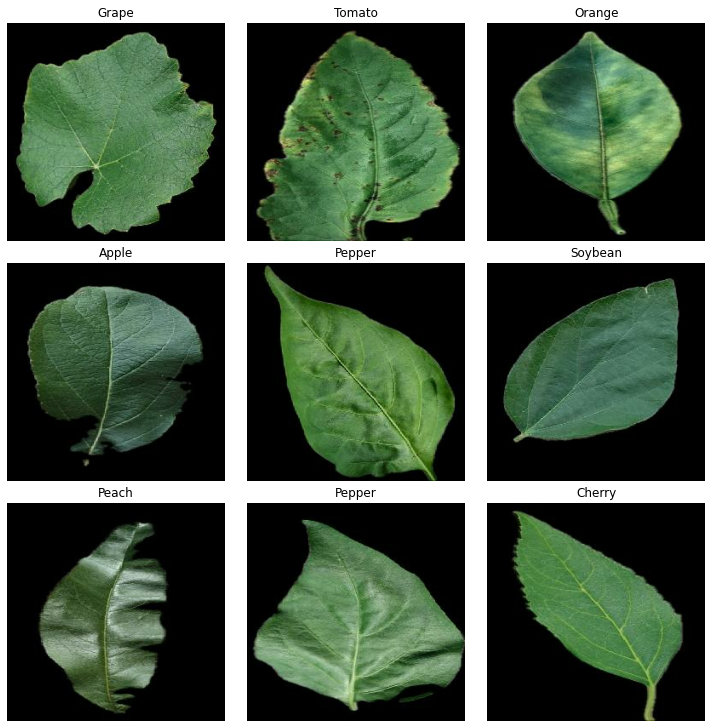

In [ ]:
# Print some samples from the training dataset:

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

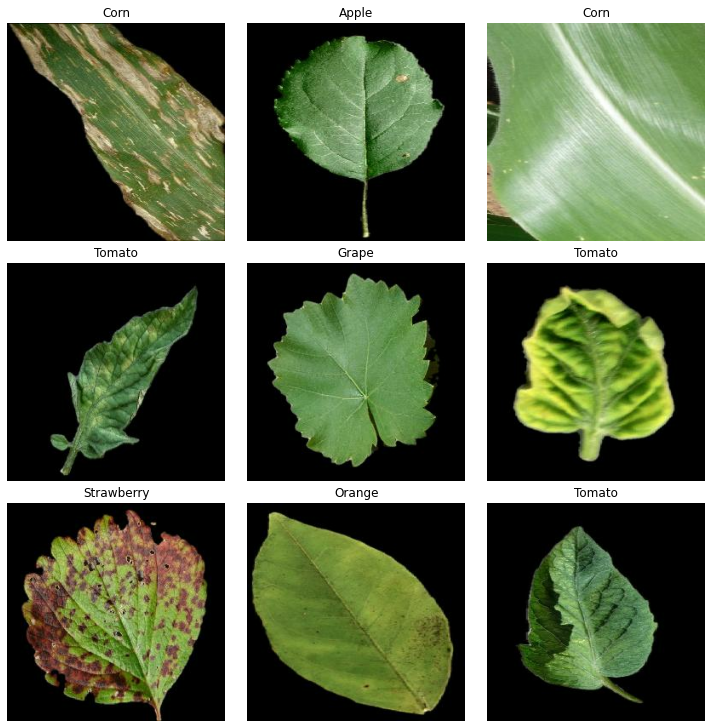

In [ ]:
# Print some samples from the validation dataset

plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [ ]:
# Batches definition:

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 89
Number of test batches: 22


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data augmentation:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

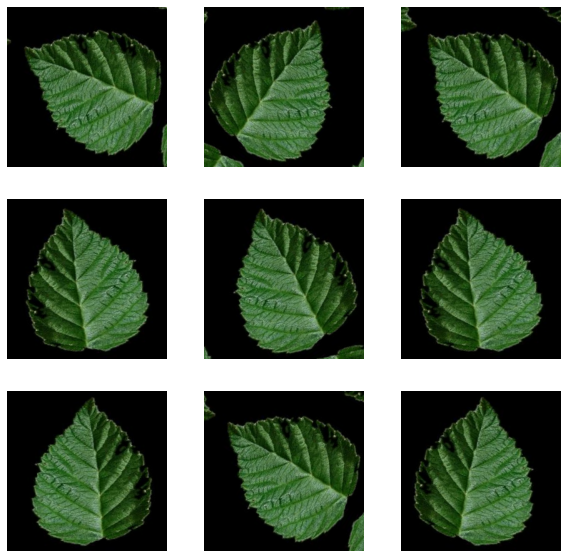

In [ ]:
# Let's plot some augmented images:

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Metrics definition:

def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [ ]:
# Build the image shape as (3, 256, 256)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
#Apply the same preprocessing used to train the supernet:

preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [ ]:
# Download the supernet without including the top part:
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2021-11-23 23:41:17.555625: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 6, 6, 1536)


In [ ]:
# Fix all the supernet:
base_model.trainable = False

In [ ]:
# Let's build the top part in order to match our class size:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 14)


In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Define the learning rate and compile the model:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [ ]:
initial_epochs = 50

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('results')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CH1_InceptionV3')

# Train this first model:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                   callbacks = aug_callbacks)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


444/444 [==============================] - 94s 189ms/step - loss: 0.7979 - tp: 8624.0000 - fp: 872.0000 - tn: 183507.0000 - fn: 5559.0000 - accuracy: 0.7612 - precision: 0.9082 - recall: 0.6081 - auc: 0.9761 - val_loss: 0.4416 - val_tp: 2261.0000 - val_fp: 133.0000 - val_tn: 36800.0000 - val_fn: 580.0000 - val_accuracy: 0.8712 - val_precision: 0.9444 - val_recall: 0.7958 - val_auc: 0.9931
Epoch 2/50
444/444 [==============================] - 80s 179ms/step - loss: 0.3986 - tp: 11592.0000 - fp: 784.0000 - tn: 183595.0000 - fn: 2591.0000 - accuracy: 0.8840 - precision: 0.9367 - recall: 0.8173 - auc: 0.9943 - val_loss: 0.2953 - val_tp: 2461.0000 - val_fp: 106.0000 - val_tn: 36827.0000 - val_fn: 380.0000 - val_accuracy: 0.9197 - val_precision: 0.9587 - val_recall: 0.8662 - val_auc: 0.9968
Epoch 3/50
444/444 [==============================] - 80s 179ms/step - loss: 0.3116 - tp: 12292.0000 - fp: 709.0000 - tn: 183670.0000 - fn: 1891.0000 - accuracy: 0.9072 - precision: 0.9455 - recall: 0.866

In [ ]:
result = model.evaluate(test_dataset)
models.save_model(model, "models/inception_v3TL")



22/22 [==============================] - 4s 150ms/step - loss: 0.0973 - tp: 680.0000 - fp: 15.0000 - tn: 9137.0000 - fn: 24.0000 - accuracy: 0.9716 - precision: 0.9784 - recall: 0.9659 - auc: 0.9989


2021-11-24 00:25:35.238754: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [ ]:
# Here starts fine tuning: let's set everything as trainable
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [ ]:
# Compile the new model:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

# New training!
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                        callbacks = aug_callbacks)

Epoch 31/100


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


444/444 [==============================] - 104s 207ms/step - loss: 0.0991 - tp: 14350.0000 - fp: 418.0000 - tn: 193113.0000 - fn: 537.0000 - accuracy: 0.9676 - precision: 0.9717 - recall: 0.9639 - auc: 0.9992 - val_loss: 0.0572 - val_tp: 2788.0000 - val_fp: 37.0000 - val_tn: 36896.0000 - val_fn: 53.0000 - val_accuracy: 0.9820 - val_precision: 0.9869 - val_recall: 0.9813 - val_auc: 0.9994
Epoch 32/100
444/444 [==============================] - 89s 200ms/step - loss: 0.0680 - tp: 13830.0000 - fp: 274.0000 - tn: 184105.0000 - fn: 353.0000 - accuracy: 0.9773 - precision: 0.9806 - recall: 0.9751 - auc: 0.9994 - val_loss: 0.0476 - val_tp: 2795.0000 - val_fp: 37.0000 - val_tn: 36896.0000 - val_fn: 46.0000 - val_accuracy: 0.9852 - val_precision: 0.9869 - val_recall: 0.9838 - val_auc: 0.9996
Epoch 33/100
444/444 [==============================] - 90s 201ms/step - loss: 0.0559 - tp: 13894.0000 - fp: 224.0000 - tn: 184155.0000 - fn: 289.0000 - accuracy: 0.9812 - precision: 0.9841 - recall: 0.9796

In [1]:
result = model.evaluate(test_dataset)

NameError: ignored

In [ ]:
models.save_model(model, "models/inception_v3TL_FT")